LINK TO DATASET : `https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction`

# Bài tập cá nhân môn Khoa học dữ liệu

## Bộ dữ liệu sử dụng : Netflix Stock Price Prediction

### Vấn đề:
    Giải quyết bài toán dự đoán giá trị cổ phiếu của Netflix :
- Khai phá dữ liệu bao gồm hình thành đặc trưng (feature) mới hay các giá trị để tăng độ chính xác cho dự báo
- Lựa chọn model Logistic Regression cho việc lựa chọn và đánh giá mô hình
- Phân chia tập dữ liệu train và test để đánh giá độ hiểu quả (Trong đó bao gồm có xử lí cross_validation)

`Import thư viện`

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform
from sklearn.model_selection import cross_validate
warnings.filterwarnings('ignore')

`Đọc file csv`

In [18]:
data = pd.read_csv('NFLX.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


`Thông tin của data`

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


`Vẽ giá cổ phiếu Netflix cho toàn bộ thời gian (5.2.2018 - 4.2.2022)`

Text(0.5, 1.0, 'Giá cổ phiếu Netflix cho toàn bộ thời gian (2018 - 2022)')

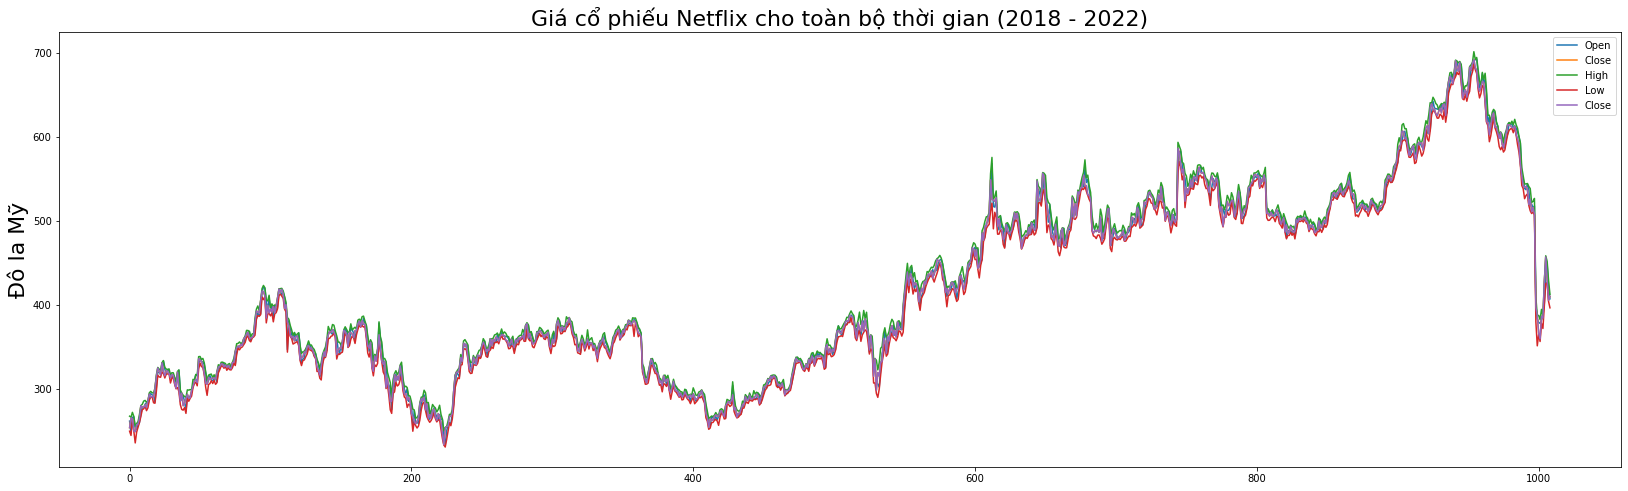

In [20]:
data[['Open', 'Close', 'High','Low','Close']].plot(figsize=(28,8))
plt.ylabel('Đô la Mỹ', fontsize = 22)
plt.title("Giá cổ phiếu Netflix cho toàn bộ thời gian (2018 - 2022)", fontsize=22)

Nếu chỉ sử dụng các biến có trong dataset thì rất khó để dự đoán vì sự biến thiên không nhiều. Bước tiếp theo chúng ta sẽ tạo thêm các đặc trưng mới.

# `Xây dựng mô hình`

`Tạo thêm đặc trưng`

'Have_Increase' - Giá trị tăng trưởng của cổ phiếu
+ Nếu giá mở cửa trừ giá đóng cửa < 0 -> giá trị sẽ bằng 0
+ Nếu giá mở cửa trừ giá đóng cửa > 0 -> giá trị sẽ bằng 1

In [21]:
conditions = [(data['Open'] - data['Close']) < 0, (data['Open'] - data['Close']) > 0]
values = [0, 1]
data['Have_Increase'] = np.select(conditions, values, default = 1)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Have_Increase
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,1
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,0
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,1
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,1
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,1


'Target' - So sánh giá trị đóng phiên trước và phiên sau
+ Nếu giá trị đóng ngày sau > giá trị đóng ngày trước -> giá trị sẽ bằng 1
+ Nếu giá trị đóng ngày sau < giá tị đóng ngày trước -> giá trị sẽ bằng 0

In [22]:
newfeatures = pd.DataFrame()
newfeatures['Target'] = data.rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
newfeatures.head()

,Target
0,NaN
1,1.0
2,0.0
3,0.0
4,0.0


In [23]:
data = data.shift(1)
data['Target'] = newfeatures['Target']
data = data.iloc[1:]
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Have_Increase,Target
1,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,1.0,1.0
2,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800.0,0.0,0.0
3,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500.0,1.0,0.0
4,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700.0,1.0,0.0
5,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900.0,1.0,1.0


`Thực hiện với tham số mặc định`

In [24]:
predictors = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume','Have_Increase']

In [29]:
def logisticRegression(data):
    accuracy_score_arr = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=i)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_score_arr.append(accuracy_score(y_test, y_pred))
    return np.array(accuracy_score_arr).mean()
    
print("Độ chính xác của thuật toán Logistic Regression: ", round(logisticRegression(data)*100,4),"%")


Độ chính xác của thuật toán Logistic Regression:  49.2079 %


`Lựa chọn siêu tham số`

In [13]:
def Select_Hyperparameters(data):
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=1)
    model = LogisticRegression()

    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = loguniform(1e-5, 100)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
    result = search.fit(X_train, y_train)

    return result.best_score_, search.best_params_
        
best_score_,best_params_= Select_Hyperparameters(data)
print("Độ chính xác đúng nhất: %f \nSử dụng bộ siêu tham số: %s" % (best_score_, best_params_))

Độ chính xác đúng nhất: 0.555777 
Sử dụng bộ siêu tham số: {'C': 0.00011762747049187036, 'penalty': 'l2', 'solver': 'newton-cg'}


`Đánh giá mô hình` - sử dụng cross validate

In [14]:
def rating_model(data, best_params_):
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=1)
    model = LogisticRegression(C = best_params_['C'], penalty = best_params_['penalty'], solver = best_params_['solver'])
    result = cross_validate(model, X_train, y_train, cv=10, scoring='accuracy', return_train_score=True)
    return np.array(result['train_score']).mean()

print(rating_model(data,best_params_))

0.558312909660872


`Sử dụng siêu tham số cấu hình cho mô hình`

In [30]:
def logisticRegressionWithHyperparameter(data, params):
    accuracy_score_arr = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=i)
        model = LogisticRegression(C = params['C'], solver = params['solver'], penalty = params['penalty'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_score_arr.append(accuracy_score(y_test, y_pred))
    return np.array(accuracy_score_arr).mean()

print("Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số:  ", round(logisticRegressionWithHyperparameter(data, best_params_)*100,4),"%")

Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số:   54.2079 %


`Độ chênh lệch giữa 2 phương pháp`

In [31]:
print("Độ sai lệch trong bộ tính toán giữa 2 cách: ", round((logisticRegressionWithHyperparameter(data, best_params_) - logisticRegression(data)) * 100,4),"%")

Độ sai lệch trong bộ tính toán giữa 2 cách:  5.0 %


# `Kết luận`
+ Sau khi lựa chọn được siêu tham số phù hợp, thuật toán cải thiện thêm 5%.

+ Với tỉ lệ dự đoán 50-50 như thế này, rất khó để có thể dự đoán chính xác giá cổ phiếu. Nhưng nếu mô hình có độ chính xác tầm 60% trở lên thì sẽ thật vô lý. Vậy thì tất cả mọi người có thể sẽ trở nên giàu có.

+ Chúng ta có thể tạo thêm những biến thể hiện tương quan giữa giá cổ phiếu hiện tại với giá cổ phiếu trung bình trong tuần, quý hoặc năm. Có thể tăng thêm 1-2% độ chính xác. Ví dụ: nếu giá hiện tại cao hơn giá hàng năm, điều đó mang ý nghĩa là cổ phiếu đang có xu hướng tăng.